In [1]:
import pandas as pd
from pathlib import Path

In [2]:
DATASET_ROOT = Path("./") # update/check this


## Loading the metadata and annotations

In [3]:
df_meta = pd.read_csv(DATASET_ROOT / "jambo_meta_public.csv", index_col="filename")
print(df_meta.head().to_markdown())

| filename                  | date   |   agreement | majority_label   | Bio1   | Bio2   | Bio3   | CV1   | CV2   | CV3   |
|:--------------------------|:-------|------------:|:-----------------|:-------|:-------|:-------|:------|:------|:------|
| 10-11Dyk1_frame_10029.png | 10-11  |    1        | stone            | stone  | stone  | stone  | stone | stone | stone |
| 10-11Dyk1_frame_10088.png | 10-11  |    0.833333 | stone            | stone  | stone  | bad    | stone | stone | stone |
| 10-11Dyk1_frame_10147.png | 10-11  |    0.666667 | stone            | stone  | bad    | bad    | stone | stone | stone |
| 10-11Dyk1_frame_10324.png | 10-11  |    0.666667 | bad              | stone  | bad    | bad    | stone | bad   | bad   |
| 10-11Dyk1_frame_10383.png | 10-11  |    1        | stone            | stone  | stone  | stone  | stone | stone | stone |


The **date** column corresponds to the date the image was captured (26/09/2023, 7/11/2023, 8/11/2023, 10/11/2023).

The **agreement** column corresponds to the agreement level amongst annotators (1 indicating full agreement - see the paper for details).

The **majority label** column indicates the majority label across annotators, as used in the paper. Note that when there is no majority (e.g. two annotators selected stone, and two selected sand), the majority label was chosen randomly.

The remaining 6 columns correspond to the labels assigned by the 6 individual annotators, as nicknamed in the paper.

In [4]:
df_annotations = pd.read_csv(DATASET_ROOT / "jambo_annotations_public.csv", index_col="filename")
print(df_annotations.head().to_markdown())

| filename                 | label   |     time | annotator   |
|:-------------------------|:--------|---------:|:------------|
| 7-11dyk1_frame_31452.png | sand    | 5.06637  | Bio3        |
| 8-11Dyk1_frame_12719.png | sand    | 0.928634 | Bio3        |
| BackDyk3_frame_19463.png | stone   | 2.10156  | Bio3        |
| 7-11dyk2_frame_30786.png | sand    | 2.34821  | Bio3        |
| BackDyk3_frame_20584.png | sand    | 0.768481 | Bio3        |


This dataframe shows the same individual annotations in a row-wise format. Additionally, the **time** column indicates how long the annotator took to annotate the image (in seconds).

## Loading train & test splits

In [5]:
df_splits = pd.read_csv(DATASET_ROOT / "jambo_splits_public.csv", index_col="filename")
print(df_splits.head())

                           date_splits  cv_split_1  cv_split_2  cv_split_3  \
filename                                                                     
10-11Dyk1_frame_10029.png            1          -1          -1          -1   
10-11Dyk1_frame_10088.png            1          -1          -1          -1   
10-11Dyk1_frame_10147.png            1           0          -1          -1   
10-11Dyk1_frame_10324.png            1          -1          -1          -1   
10-11Dyk1_frame_10383.png            1          -1          -1          -1   

                           cv_split_4  cv_split_5  cv_split_6  cv_split_7  \
filename                                                                    
10-11Dyk1_frame_10029.png          -1          -1           0          -1   
10-11Dyk1_frame_10088.png          -1          -1          -1          -1   
10-11Dyk1_frame_10147.png          -1          -1          -1          -1   
10-11Dyk1_frame_10324.png          -1          -1          -1       

This dataframe provides the train/test splits used in the paper (date-based and cross-validation splits).
The splits are provided in the format expected by ``sklearn.model_selection.PredefinedSplit``.

An example using the date-based splits:

In [6]:
from sklearn.model_selection import PredefinedSplit

folds = df_splits["date_splits"]
ps = PredefinedSplit(folds)
ps.get_n_splits()
print(ps)

for i, (train_index, test_index) in enumerate(ps.split()):
    print(f"Fold {i}:")
    print(f"  Train dates ={df_meta['date'].iloc[train_index].unique()}")
    print(f"  Test dates={df_meta['date'].iloc[test_index].unique()}")

PredefinedSplit(test_fold=array([1, 1, ..., 2, 2]))
Fold 0:
  Train dates =['10-11' '8-11' '26-09']
  Test dates=['7-11']
Fold 1:
  Train dates =['7-11' '8-11' '26-09']
  Test dates=['10-11']
Fold 2:
  Train dates =['10-11' '7-11' '8-11']
  Test dates=['26-09']


## Visualizing images

First we define a helper function which resizes images and creates a mosaic:

In [7]:
from PIL import Image, ImageFont, ImageDraw, ImageOps
import numpy as np

def display_images(imgs_list, num_images=30, img_root=Path(DATASET_ROOT / "images/"),split_at = 10,RESIZE = True,resize_to=224):
    num_images_selected = min(len(imgs_list),num_images)
    split_at_selected = min(split_at,num_images_selected)

    if len(imgs_list) > num_images:
        idx = np.random.choice(range(len(imgs_list)),num_images_selected,replace=False)
    else:
        idx = range(len(imgs_list))

    img_selected = [imgs_list[i] for i in idx]
    img_selected_paths = [img_root / img_path for img_path in img_selected]
    desired_size = resize_to
    if RESIZE:
        images = [Image.open(x).resize((desired_size,desired_size)) if (Image.open(x).size[0] != desired_size or Image.open(x).size[1] != desired_size) else Image.open(x) for x in img_selected_paths]
    else:
        images =  [Image.open(x) for x in img_selected_paths]
    widths, heights = zip(*(i.size for i in images))
    
    total_width = int(sum(widths) / (num_images_selected/split_at_selected))
    max_height = int(max(heights) * np.ceil(num_images_selected/split_at_selected))
    
    new_im = Image.new('RGB', (total_width, max_height))
    
    x_offset = 0
    for i,im in enumerate(images):
      img_height = desired_size if RESIZE else heights[i]
      if i < split_at:
          y_offset = 0
      elif (i % split_at) == 0:
          y_offset = img_height * (i // split_at_selected)
          x_offset = 0
      new_im.paste(im, (x_offset,y_offset))
      #print(im.size)
      x_offset += im.size[0]
    
    #new_im.show()
    display(new_im)

Example usage, creating a 100-image mosaic for a specific date:

10-11


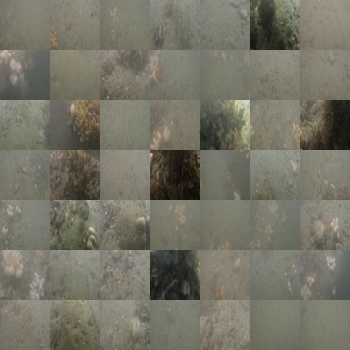

In [8]:
date = df_meta["date"].unique()[0]
print(date)
img_names = list(df_meta[(df_meta['date'] == date)].index )
display_images(img_names,split_at=7, num_images=49, resize_to=50)